# Graph Neural Networks

In this tutorial, we will explore the implementation of graph neural networks and investigate what representations these networks learn. Along the way, we'll see how PyTorch Geometric and TensorBoardX can help us with constructing and training graph models.

## Preliminary Imports

PyTorch is a general machine learning library that allows us to dynamically define computation graphs which we'll use to describe our models and their training processes.

We'll start by importing everything we need:

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import sklearn.metrics as metrics

We'll first download and load in a dataset (here the MNIST handwritten digits dataset) through the `DataLoader` utility:

In [2]:
BATCH_SIZE = 32

## transformations
transform = transforms.Compose([transforms.ToTensor()])

## download and load training dataset // "True"= data not in local, "Flase"= data needs to be laoded from local
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)

## download and load testing dataset
testset = torchvision.datasets.MNIST(root='./data', train=False, download=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

#### Data shape

In [58]:
trainset.train_data.shape, testset.train_data.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

Our goal here will be to train a model to classify pictures of digits from 1 to 10. Let's define the model we'll use for this task, which will consist of a convolutional layer followed by two fully-connected layers. Our model is a subclass of `nn.Module`; modules must implement a `forward()` function which defines exactly what operations get applied to the inputted data.

Note that `MyModel` makes uses of the predefined modules `Conv2d` and `Linear`, which it instantiates in its constructor. Running data `x` through a module `conv1` simply consists of calling it like a function: `out = conv1(x)`.

In [34]:
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        
        #28*28*1 => 26*26*32
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3)
        self.d1 = nn.Linear(26*26*32, 128)
        self.d2 = nn.Linear(128,10)
        
    def forward(self, x):
        #32*1*28*28 => 32*32*26*26
        x = self.conv1(x)
        x = F.relu(x)
        
        # flatten => 32 * (32*26*26)
        x = x.flatten(start_dim=1)
        #x = x.view(32, -1) // computationally efficient
        
        # 32 * (32*26*26) => 32*128
        x = self.d1(x)
        x = F.relu(x)
        
        # logits => 32*10
        logits = self.d2(x)
        out = F.softmax(logits, dim=1)
        return out

In [19]:
# Some basic matrix multiplications using GPU
import numpy as np
a = np.array([[1,2],[3,4]])
b = np.ones((2,2))

ta = torch.tensor(a, dtype=float).cuda()
tb = torch.ones((2,2), dtype=float).cuda()

print(tb)
print(ta @ tb)

tensor([[1., 1.],
        [1., 1.]], device='cuda:0', dtype=torch.float64)
tensor([[3., 3.],
        [7., 7.]], device='cuda:0', dtype=torch.float64)


We train our model, printing out its training accuracy along the way. We start by instantiating a model instance `model`, a loss function module `criterion` and optimizer `optimizer`, which will adjust the parameters of our model in order to minimize the loss output by `criterion`.

In [42]:
lr = 0.001
num_epochs = 5

# Specifying the computation prefrences
device = torch.device("cuda:0")

# initializing the model and defining the optimizaton strategy
model = MyModel()
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Now let's write our training loop. For each minibatch (accessed by enumerating through our data loader `trainloader`), we run our data through `model` in a forward pass, then compute the loss with `criterion`. We call `optimizer.zero_grad()` to zero out the gradients from the previous round of training, followed by `loss.backward()` to backpropagate the new round of gradients and finally `optimizer.step()` to adjust the model parameters based on these gradients.

In [48]:
for epoch in range(num_epochs):
    train_running_loss = 0.0
    train_acc = 0.0

    ## training step
    for i, (images, labels) in enumerate(trainloader):
        
        images = images.to(device)
        labels = labels.to(device)

        ## forward + backprop + loss
        logits = model(images)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()

        ## update model params
        optimizer.step()

        train_running_loss += loss.detach().item()
        train_acc += (torch.argmax(logits, 1).flatten() == labels).type(torch.float).mean().item()
    
    print('Epoch: %d | Loss: %.4f | Train Accuracy: %.2f' \
          %(epoch, train_running_loss / i, train_acc/i))

Epoch: 0 | Loss: 1.4727 | Train Accuracy: 0.99
Epoch: 1 | Loss: 1.4711 | Train Accuracy: 0.99
Epoch: 2 | Loss: 1.4700 | Train Accuracy: 0.99
Epoch: 3 | Loss: 1.4694 | Train Accuracy: 0.99
Epoch: 4 | Loss: 1.4689 | Train Accuracy: 0.99


Lastly, we can run just the forward pass of our model in order to run it on the test set.

In [60]:
test_acc = 0.0
for i, (images, labels) in enumerate(testloader, 0):
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    test_acc += (torch.argmax(outputs, 1).flatten() == labels).type(torch.float).mean().item()
    #pred =  torch.argmax(outputs, 1).flatten().cpu().numpy()
print('Test Accuracy is: %.2f' %(test_acc/i))

Test Accuracy is: 0.99


## Pytorch Geometrics

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

import time
from datetime import datetime

import networkx as nx
import numpy as np
import torch
import torch.optim as optim

from torch_geometric.datasets import TUDataset, Planetoid
from torch_geometric.data import DataLoader

import torch_geometric.transforms as T

from tensorboardX import SummaryWriter
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Defining the model

The `GNNStack` is our general framework for a GNN which can handle different types of convolutional layers, and both node and graph classification. The `build_conv_model` method determines which type of convolutional layer to use for the given task -- here we choose to use a graph convolutional network for node classification, and a graph isomorphism network for graph classification. Note that PyTorch Geometric provides out-of-the-box modules for these layers, which we use here. The model consists of 3 layers of convolution, followed by mean pooling in the case of graph classification, followed by two fully-connected layers. Since our goal here is classification, we use a negative log-likelihood loss function.

In [2]:
class GNNStack(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, task='node'):
        super(GNNStack, self).__init__()
        self.task = task
        self.convs = nn.ModuleList()
        self.convs.append(self.build_conv_model(input_dim, hidden_dim))
        self.lns = nn.ModuleList()
        self.lns.append(nn.LayerNorm(hidden_dim))
        self.lns.append(nn.LayerNorm(hidden_dim))
        for l in range(2):
            self.convs.append(self.build_conv_model(hidden_dim, hidden_dim))

        # post-message-passing
        self.post_mp = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim), nn.Dropout(0.25), 
            nn.Linear(hidden_dim, output_dim))
        if not (self.task == 'node' or self.task == 'graph'):
            raise RuntimeError('Unknown task.')

        self.dropout = 0.25
        self.num_layers = 3

    def build_conv_model(self, input_dim, hidden_dim):
        # refer to pytorch geometric nn module for different implementation of GNNs.
        if self.task == 'node':
            return pyg_nn.GCNConv(input_dim, hidden_dim)
        else:
            return pyg_nn.GINConv(nn.Sequential(nn.Linear(input_dim, hidden_dim),
                                  nn.ReLU(), nn.Linear(hidden_dim, hidden_dim)))

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        if data.num_node_features == 0:
          x = torch.ones(data.num_nodes, 1)

        for i in range(self.num_layers):
            x = self.convs[i](x, edge_index)
            emb = x
            x = F.relu(x)
            x = F.dropout(x, p=self.dropout, training=self.training)
            if not i == self.num_layers - 1:
                x = self.lns[i](x)

        if self.task == 'graph':
            x = pyg_nn.global_mean_pool(x, batch)

        x = self.post_mp(x)

        return emb, F.log_softmax(x, dim=1)

    def loss(self, pred, label):
        return F.nll_loss(pred, label)

Here pyg_nn.GCNConv and pyg_nn.GINConv are instances of MessagePassing. They define a single layer of graph convolution, which can be decomposed into:
* Message computation
* Aggregation
* Update
* Pooling

Here we give an example of how to subclass the pytorch geometric MessagePassing class to derive a new model (rather than using existing GCNConv and GINConv).

We make use of `MessagePassing`'s key building blocks:
- `aggr='add'`: The aggregation method to use ("add", "mean" or "max").
- `propagate()`: The initial call to start propagating messages. Takes in the edge indices and any other data to pass along (e.g. to update node embeddings).
- `message()`: Constructs messages to node i. Takes any argument which was initially passed to propagate().
- `update()`: Updates node embeddings. Takes in the output of aggregation as first argument and any argument which was initially passed to propagate().


In [3]:
class CustomConv(pyg_nn.MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(CustomConv, self).__init__(aggr='add')  # "Add" aggregation.
        self.lin = nn.Linear(in_channels, out_channels)
        self.lin_self = nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Add self-loops to the adjacency matrix.
        edge_index, _ = pyg_utils.remove_self_loops(edge_index)

        # Transform node feature matrix.
        self_x = self.lin_self(x)
        #x = self.lin(x)

        return self_x + self.propagate(edge_index, size=(x.size(0), x.size(0)), x=self.lin(x)) # Jumping Neural Nets

    def message(self, x_i, x_j, edge_index, size):
        # Compute messages
        # x_j has shape [E, out_channels]

        row, col = edge_index
        deg = pyg_utils.degree(row, size[0], dtype=x_j.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        return x_j

    def update(self, aggr_out):
        # aggr_out has shape [N, out_channels]
        return aggr_out

# Training setup

We train the model in a standard way here, running it forwards to compute its predicted label distribution and backpropagating the error. Note the task setup in our graph setting: for node classification, we define a subset of nodes to be training nodes and the rest of the nodes to be test nodes, and mask out the test nodes during training via `batch.train_mask`. For graph classification, we use 80% of the graphs for training and the remainder for testing, as in other classification settings.

In [5]:
def train(dataset, task, writer):
    if task == 'graph':
        data_size = len(dataset)
        loader = DataLoader(dataset[:int(data_size * 0.8)], batch_size=64, shuffle=True)
        test_loader = DataLoader(dataset[int(data_size * 0.8):], batch_size=64, shuffle=True)
    else:
        test_loader = loader = DataLoader(dataset, batch_size=64, shuffle=True)

    # build model
    model = GNNStack(max(dataset.num_node_features, 1), 32, dataset.num_classes, task=task)
    opt = optim.Adam(model.parameters(), lr=0.01)
    
    # train
    for epoch in range(200):
        total_loss = 0
        model.train()
        for batch in loader:
            #print(batch.train_mask, '----')
            opt.zero_grad()
            embedding, pred = model(batch)
            label = batch.y
            if task == 'node':
                pred = pred[batch.train_mask]
                label = label[batch.train_mask]
            loss = model.loss(pred, label)
            loss.backward()
            opt.step()
            total_loss += loss.item() * batch.num_graphs
        total_loss /= len(loader.dataset)
        writer.add_scalar("loss", total_loss, epoch) ## for Plotting 

        if epoch % 10 == 0:
            test_acc = test(test_loader, model)
            print("Epoch {}. Loss: {:.4f}. Test accuracy: {:.4f}".format(
                epoch, total_loss, test_acc))
            writer.add_scalar("test accuracy", test_acc, epoch)

    return model

Test time, for the CiteSeer/Cora node classification task, there is only 1 graph. So we use masking to determine validation and test set.

For graph classification tasks, a subset of graphs is considered validation / test graph.

In [6]:
def test(loader, model, is_validation=False):
    model.eval()

    correct = 0
    for data in loader:
        with torch.no_grad():
            emb, pred = model(data)
            pred = pred.argmax(dim=1)
            label = data.y

        if model.task == 'node':
            mask = data.val_mask if is_validation else data.test_mask
            # node classification: only evaluate on nodes in test set
            pred = pred[mask]
            label = data.y[mask]
            
        correct += pred.eq(label).sum().item()
    
    if model.task == 'graph':
        total = len(loader.dataset) 
    else:
        total = 0
        for data in loader.dataset:
            total += torch.sum(data.test_mask).item()
    return correct / total

# Training the model

Now run this snippet to start the training. When it's finished, you should be able to see its training and test performance over time on the TensorBoardX page. If you run the snippet multiple times, you will be able to see multiple training curves and compare them.

We start with a graph classification task on the IMDB-BINARY dataset.

In [33]:
import tensorboardX
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = TUDataset(root='/tmp/IMDB-BINARY', name='IMDB-BINARY')
dataset = dataset.shuffle()
task = 'graph'

model = train(dataset, task, writer)
writer.close()

C:\Users\ThinkStation_P620\miniconda3\envs\torch_pyg\lib\site-packages\torch_geometric\deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Epoch 0. Loss: 0.7183. Test accuracy: 0.4600
Epoch 10. Loss: 0.6909. Test accuracy: 0.5500
Epoch 20. Loss: 0.6018. Test accuracy: 0.6750
Epoch 30. Loss: 0.5872. Test accuracy: 0.6650
Epoch 40. Loss: 0.5724. Test accuracy: 0.6750
Epoch 50. Loss: 0.5702. Test accuracy: 0.6000
Epoch 60. Loss: 0.5716. Test accuracy: 0.6850
Epoch 70. Loss: 0.6083. Test accuracy: 0.6650
Epoch 80. Loss: 0.5614. Test accuracy: 0.6500
Epoch 90. Loss: 0.5627. Test accuracy: 0.6300
Epoch 100. Loss: 0.5695. Test accuracy: 0.6900
Epoch 110. Loss: 0.5674. Test accuracy: 0.5750
Epoch 120. Loss: 0.5554. Test accuracy: 0.6650
Epoch 130. Loss: 0.5667. Test accuracy: 0.6750
Epoch 140. Loss: 0.5718. Test accuracy: 0.6600
Epoch 150. Loss: 0.5729. Test accuracy: 0.6650
Epoch 160. Loss: 0.5598. Test accuracy: 0.6850
Epoch 170. Loss: 0.5679. Test accuracy: 0.6800
Epoch 180. Loss: 0.5699. Test accuracy: 0.6750
Epoch 190. Loss: 0.5588. Test accuracy: 0.6500


Here we try a node classification task on the Citeseer citation network:

In [35]:
writer = SummaryWriter("./log/" + datetime.now().strftime("%Y%m%d-%H%M%S"))

dataset = Planetoid(root='/tmp/cora', name='cora')
task = 'node'

model = train(dataset, task, writer)

URLError: <urlopen error [Errno 11004] getaddrinfo failed>

# Visualizing node embeddings

One great quality about graph neural networks is that, like other deep methods, their hidden layers provide low-dimensional representations of our data. In the case of node classification, we get a low-dimensional representation for each node in our graph. Let's visualize the output of the last convolutional layer in our node classification GNN via TSNE, a method for plotting high-dimensional data. Nodes are colored according to their labels. We see that nodes with similar labels tend to be near each other in the embedding space, a good indication that our model has learned a useful representation.

C:\Users\ThinkStation_P620\miniconda3\envs\torch_pyg\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\ThinkStation_P620\miniconda3\envs\torch_pyg\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: 'c' argument has 1000 elements, which is inconsistent with 'x' and 'y' with size 19773.

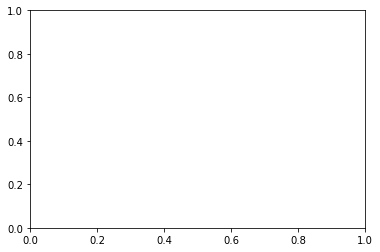

In [34]:
color_list = ["red", "orange", "green", "blue", "purple", "brown"]

loader = DataLoader(dataset, batch_size=64, shuffle=True)
embs = []
colors = []
for batch in loader:
    emb, pred = model(batch)
    embs.append(emb)
    colors += [color_list[y] for y in batch.y]
embs = torch.cat(embs, dim=0)

xs, ys = zip(*TSNE().fit_transform(embs.detach().numpy()))
plt.scatter(xs, ys, color=colors)